# ECON GA- 4003 Project Data Report

# Country Level Analysis of Happiness and Peace


### Authors: Syeda Naveera Fatima Rizvi and Suniya Raza

## Introduction

In this project we analyze the general happiness level and peace values of countries around the world. We analyze the time trends of the average 
values of this indices for both the top and worse performing countries. We do a special focus on Afghanistan where we see how major political events
have impacted the happiness index values for this country. We also analyze the correlation between the happiness index and factors such as 
healthy life expectancy, log gdp per capita, social support, freedom to make life choices and perception of corruption. Finally we look at how geographical proximity plays a role on index values. 

A significant step in this project aims to see see whether countries who have a female head of state fare better on these indices than male led countries.
Following reports of how female-led countries such as New Zealand (Jacinda Ardern) and Germany (Angela Merkel) had a superior performance during
the pandemic, we first focus on the year 2020. We see wether averages of the index values (both peace and happiness) differed by the gender of the head of state. We then extend our analysis to the entire 2008-2020 time period and check wether these differences have persisted across time.
We also see what percentage of head of states were female in both the top and worst 10 countries (for peace and happiness seperately) in each year.

This report finds that there are infact gendered differences and female-led countries performed well not only during the pandemic year but also throughout the 2008-2020 time period.

## Getting the data

We download 3 main datasets for our analysis:

1. Data for Peace Index. This is a Global Peace Index measuring the peacefulness of a country. This index orginally ranges from 1-5, where lower values represent more peacefullness in a country. We have downloaded this dataset from the [vision of humanity](https://www.visionofhumanity.org/) website. The downloaded dataset is provided as a supplemnatry file in this project and we simply read this file for our analysis <br> <br>
***Key Variables: Year, Country, Peace_index*** <br> <br>
This data has been produced by the Institute for Economics and Peace (IEP) under the guidance of an international panel of independent experts.  <br> <br>
Note: To make the peace index consistent with the happier index for easier analysis, we transform the peace index data such that it ranges on a 1-10 scale with higher index values now representing higher peacefullness.<br> <br>

2.  Data for Happiness Index. This is a Cantril ladder Score which is meant to represent happiness or subjective well-being. Respondents are asked to imagine a ladder with steps numbered from 0 to 10. They are then asked to rate their current lives based on where they consider themselves to stand on the ladder, with step 0 is the worst possible life and step 10 is the best one. We download the data for the happiness index using an API request from the [World Happiness Report](https://worldhappiness.report/ed/2021/) published in the year 2021. <br> <br> 
***Key Variables: Year, Country, Life Ladder (Happiness index)*** <br> <br>
Other than the happinesss index, we also have data for the  six factors which are supposed to contribute to the level of happiness. <br> <br>
These are: <br> 
    -Log GDP per Capita <br>
    -Healthy life expectancy <br>
    -Social Support <br>
    -Freedom to make Life Choices. <br>
    -Generosity <br>
    -Perception of Corruption <br><br>
Full details on the variables can be found in this [appendix](https://happiness-report.s3.amazonaws.com/2021/Appendix1WHR2021C2.pdf) <br><br>
The World Happiness Report is a publication of the Sustainable Development Solutions Network, powered by data from the Gallup World poll and Lloyd’s Register Foundation, who provided access to the World Risk Poll. The 2021 Report includes data from the ICL-YouGov Behaviour Tracker as part of the COVID Data Hub from theInstitute of Global Health Innovation <br> <br>

3. Data for Female Head of States. This data lists female head of states and government who were appointed by a governing committee or parliament. It includes Presidents, Prime Ministers and Chancellors. The dataset includes the name of the countries these women mandated on as well as the start and end dates of the mandate. We scrape this data using scrapy from the Wikipedia page for [List of elected and appointed female heads of state and government](https://en.wikipedia.org/wiki/List_of_elected_and_appointed_female_heads_of_state_and_government). <br> 
We have already scraped the data and we provide it as csv in the zip folder containing this project. We also provide the spider python file used to crawl the data. <br> <br>
Inisde this zip folder there is a folder named female_heads_data. Inside it there is csv named fem_head. This csv contains our data and we simply read this file for our analysis. The folder additionally has a subfolder also named as female_head_data. This subfolder contains a folder named spiders which contains a python source file named fem_head. This is the spider file we used to crawl the data. <br><br>
The steps required to create this spider file, crawl the webpage and store the data in the csv are are provided in the Appendix at the end of this report.<br> <br>
***Key Variables: Female Head of State Name (Name), Country Name (Country), LMandate Start Date, Mandate End Dateife Ladder (Happiness index)*** <br> <br>

The code below reads and cleans the data for our analysis

In [1]:
#Import Packages and set warnings off

import pandas as pd 
import requests
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import matplotlib.colors as mplc
import seaborn as sns
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go

pd.options.mode.chained_assignment = None


#Set Default values for Graphics

#Default fig size
def_size=(20,8)
#Default font for Labels
def_font = {'family': 'serif',
        'weight': 'bold',
        'size':16
        }
#Default font for Titles
def_font_title = def_font.copy()
def_font_title['size']= 30

#Default background color
background= tuple(np.array([255, 240, 255]) / 255)

In [2]:
#Read and Clean Peace Index Data

peace_index= pd.read_excel("GPI.xlsx", sheet_name="Overall Scores").iloc[2:,:16] #Read Excel file

#Cleaning

peace_index.columns= peace_index.iloc[0] #Set Column names equal to the first row
peace_index=peace_index.drop([2], axis=0) #Drop uneccessary row

peace_index=peace_index.set_index(["Country",'iso3c']).T.unstack().reset_index().rename(
    columns={2:'Year', 0:'Peace_index','iso3c':"Code"}) #Reshape data from wide to long format 

peace_index["Peace_index"]= peace_index["Peace_index"].astype(float) #Convert Index Values for float

peace_index["Peace_index"]= 2*(5-peace_index["Peace_index"]) #Transform index values to make it consistent with the happiness index values

In [3]:
#Read (via an API request) and Clean Happiness Index Data

url_happiness = "https://happiness-report.s3.amazonaws.com/2021/DataPanelWHR2021C2.xls" #Set url 
resp2 = requests.get(url_happiness)        #Get API Request

if resp2.status_code>199:
    df_happiness= pd.read_excel(resp2.content) #Read request content
    df_happiness=df_happiness.rename(columns={'Country name':'Country', 'year':'Year','Life Ladder':'Happiness_index'}) #Rename coloumns

    #Cleaning in happiness index

    #Rename country names in the happiness index dataframe to match names in the peace index data

    dict1={'Congo (Kinshasa)':'Democratic Republic of the Congo', 'Congo (Brazzaville)':'Republic of the Congo', 
     'United States':'United States of America', 'Palestinian Territories':'Palestine', 
     'Gambia':'The Gambia', 'Taiwan Province of China':'Taiwan', 'Kyrgyzstan':'Kyrgyz Republic',
     "Ivory Coast":"Cote d' Ivoire"}
    df_happiness= df_happiness.replace({'Country':dict1})
else:
    raise ValueError(f"Response error with code {resp2.status_code}")


We create a master data file by merging the Peace and Hapiness Index dataframes on country and year. We keep values from both datasets

In [4]:

master_file=df_happiness.merge(peace_index, how='outer', on=['Country', 'Year'])
master_file.head()

,Country,Year,Happiness_index,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Code,Peace_index
0,Afghanistan,2008,3.723590,7.370100,0.450662,50.799999,0.718114,0.167640,0.881686,0.517637,0.258195,AFG,3.742
1,Afghanistan,2009,4.401778,7.539972,0.552308,51.200001,0.678896,0.190099,0.850035,0.583926,0.237092,AFG,3.460
2,Afghanistan,2010,4.758381,7.646709,0.539075,51.599998,0.600127,0.120590,0.706766,0.618265,0.275324,AFG,3.758
3,Afghanistan,2011,3.831719,7.619532,0.521104,51.919998,0.495901,0.162427,0.731109,0.611387,0.267175,AFG,3.756
4,Afghanistan,2012,3.782938,7.705479,0.520637,52.240002,0.530935,0.236032,0.775620,0.710385,0.267919,AFG,3.518



We describe the data below. We have a total of 2556 observations for 173 countries. Our data is from the years 2005-2021 (a total of 16 years).
However for most of our analysis we restrict our years from 2008-2020 (12 years) as this is the time period for which we have data for both indices.

The minimum of Happiness Index is 2.37 (worst possible life) and the maximum is 8.02 (best possible life) with a mean of 5.47. 

The minimum of Peace Index is 2.7 (least peaceful) and the maximum is 7.81 (most peacefil) with a mean of 5.86.

In [5]:
master_file.describe(include='all').iloc[[0,1,2,3,4,6,10],[0,1,2,12]]

,Country,Year,Happiness_index,Peace_index
count,2556,2556.000000,1949.000000,2271.000000
unique,173,NaN,NaN,NaN
top,Saudi Arabia,NaN,NaN,NaN
freq,16,NaN,NaN,NaN
mean,NaN,2013.793427,5.466707,5.865229
min,NaN,2005.000000,2.375092,2.704000
max,NaN,2021.000000,8.018934,7.814000


In [6]:
#Reading and Cleaning Female Head of State Data

F_Head_of_State= pd.read_csv("female_heads_data//fem_head.csv").rename(columns={'Start_Date':'Start_date','End_Date':'End_date'}) #Read CSV
#Converting Dates to datetime format
F_Head_of_State['Start_date']= pd.to_datetime(F_Head_of_State['Start_date'])
F_Head_of_State['End_date']= pd.to_datetime(F_Head_of_State['End_date'])

#Cleaning Female Head of State data

#Rename country names to match the names in the master file
dict2={'Ceylon':'Sri Lanka', 'Republic of Macedonia':'North Macedonia', 'Kyrgyzstan':'Kyrgyz Republic'}

F_Head_of_State= F_Head_of_State.replace({'Country':dict2})

F_Head_of_State.head()

,Name,Country,Start_date,End_date
0,Khertek Anchimaa-Toka,Tannu Tuva,1940-04-06,1944-10-11
1,Sükhbaataryn Yanjmaa,Mongolia,1953-09-07,1954-07-07
2,Sirimavo Bandaranaike,Sri Lanka,1960-07-21,1965-03-27
3,Sirimavo Bandaranaike,Sri Lanka,1970-05-29,1977-07-23
4,Indira Gandhi,India,1966-01-24,1977-04-24


We describe this data below. Our data list 142 unique female head of states from 90 unique countries.

Lithuania has had 5 terms with female head of states making it the state with the highest number of terms with a  
female head in our Data.

Gro Harlem Brundtland from Norway has had the most terms in office i.e 3.

Note: The end date of 2022-01-31 was just a future value we assigned to heads of states who were still in power. This was done in the scrapy file we
used to scrape the data


In [7]:
F_Head_of_State.describe(include='all',datetime_is_numeric=True).iloc[[0,1,2,3,5,9],:]

,Name,Country,Start_date,End_date
count,162,162,162,162
unique,142,90,NaN,NaN
top,Gro Harlem Brundtland,Moldova,NaN,NaN
freq,3,5,NaN,NaN
min,NaN,NaN,1940-04-06 00:00:00,1944-10-11 00:00:00
max,NaN,NaN,2022-01-27 00:00:00,2022-01-31 00:00:00


## Graphics

### Time trends of Happiness and Peace Indices in High and Low Ranked Countries

In this section we identify the top three and worse three countries for each index and then visualize their trends across time. We do our analysis for each index seperately.

To identify the top and worse three countries for each index (Happiness or Peace), we rank countries based on the average value for the respective index. For each country, we calculate the average of the index across the entire time period. Once the relevant countries are identified, we then analyze the time trend for their index values in the original dataset.

Note: For some countries in the happiness index dataset there was a lot of missing data. For a fair comparison in the happiness index analysis, we drop countries which had less than 7 observations for this index. We choose 7 as a criteria as this is the half of the total number of years in the happiness index dataset. The Peace index dataset did not suffer from this problem and so we don't drop countries from it.



In [8]:
#finding countries with less than 7 observations in the Happiness Index dataset 
HI_count=pd.DataFrame(df_happiness.groupby('Country')['Happiness_index'].count()).reset_index().rename(
    columns={'Happiness_index':'HI_count'})  #Count of Countries 

#Merge count values in the original dataset and drop countries with less than 7 observations
df_happiness_2=pd.merge(df_happiness, HI_count, on='Country', how='outer')
df_happiness_2.drop(df_happiness_2.index[df_happiness_2['HI_count'] < 7], inplace=True) 

#Calculate average values for each country in the entire panel dataset
#These values will be used for ranking

avg_index_HI= df_happiness_2.groupby(["Country"])[['Happiness_index']].mean() #Average of happiness
avg_index_PI=peace_index.groupby(["Country"])[['Peace_index']].mean() #Average of peace

The code below defines a function named plot_trends which we will use to plot our trends``

In [9]:
def plot_trends(index,ax):

    """
    This function takes in an index name and then plots the time trends for the top 
    and bottom 3 countries for the respective index.
    
    The function creates a copy of the relevant average dataset made earlier (avg_index_HI 
    for happiness and avg_index_PI for peace), sorts this data on the average index values, 
    and creates a list named countries which stores the names of the top and bottom 3 countries.

    Lineplots for these countries are drawn using data from the master data file.
    We use the seaborn library with the deep color palette.
    
    Paramters
    ---------
    index: string
        The name of the relevant index (Happiness/Peace )for the trend
    
    ax: axes object
        Empty axes on which we will plot the data
        
    Returns
    -------
    ax: axes object
        The axes object updated with our plot
    """
    
    assert (index=="Happiness") | (index=="Peace")
    
    index_col= index+"_index"

    if index=="Happiness":
        df= avg_index_HI.copy()
    else:
        df= avg_index_PI.copy()
    
    df= df.sort_values(index_col,ascending=False)
    top= df.head(3).index #Names of top 3 countries
    bot= df.tail(3).index #Names of bottom 3 countries

    countries=top.append(bot) #Names appended in a single list
    
    #Filter master file and only keep the subset of countries which belong in our list
    d = master_file.loc[master_file['Country'].isin(countries),[index_col, 'Year', 'Country']].dropna()
    
    #Plot
    sns.lineplot(
        ax=ax,x=d['Year'],
         y=d[index_col], 
         hue=d['Country'],  
         dashes=False, lw=3, 
         palette="deep",legend=False
         )

    #Set titles, labels and background color 
    ax.set_title(index+' Time Trend: High vs. Low Ranked Countries', loc='center', fontdict=def_font_title)
    ax.set_xlabel('Year', fontdict=def_font)
    ax.set_ylabel(index+' Index', fontdict=def_font)
    fig.set_facecolor(background)
  
    return ax

    

***Happiness Index***

The code below plots the trend for the Happiness Index

Text(2016.8, 4.45, 'Togo')

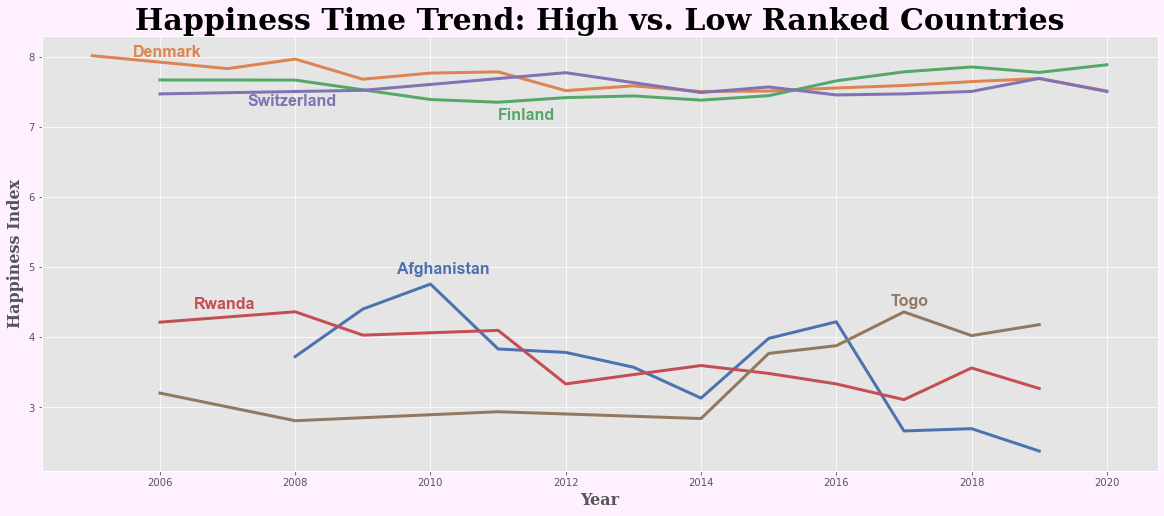

In [10]:
fig, ax = plt.subplots(figsize=def_size)
plot_trends("Happiness",ax)

#Add customized annotations

color_list = sns.color_palette("deep") #Identify colors to match text color with the line plot color

font= def_font.copy()
font['family']= 'Arial'  #Use a different family for annotations

#Add text for annotations
ax.text(2005.6,8,"Denmark",color=color_list[1],fontdict=font)
ax.text(2007.3,7.3,"Switzerland",color=color_list[4],fontdict=font)
ax.text(2011,7.1,"Finland",color=color_list[2],fontdict=font)

ax.text(2006.5,4.4,"Rwanda",color=color_list[3],fontdict=font)
ax.text(2009.5,4.9,"Afghanistan",color=color_list[0],fontdict=font)
ax.text(2016.8,4.45,"Togo",color=color_list[5],fontdict=font)


We visualize the time trend of happiness index of the 3 countries with the highest average happiness index value as well as the 3 countries with the lowest average. The chart shows that as opposed to the top ranked countries, the happiness index trends of low ranked countries are more volatile. For top ranking countries, the happiness index approximately stays between 7.3 to 8, where as for low ranked countries the happiness index has greater variation; from around 2.5 to 4.8.

Thus the plot above shows that happier countries tend to have relatively stable index values across the years
<break>
    
    
We also take a case in point and analyse the time trend of Afghanistan, the second worst ranked country in average happiness index values. We choose this country as its time trend appears to be the most volatile. The rise and fall in the happiness index values can be clearly linked to the events of the War on Terror and the civil and political unrest in the country:

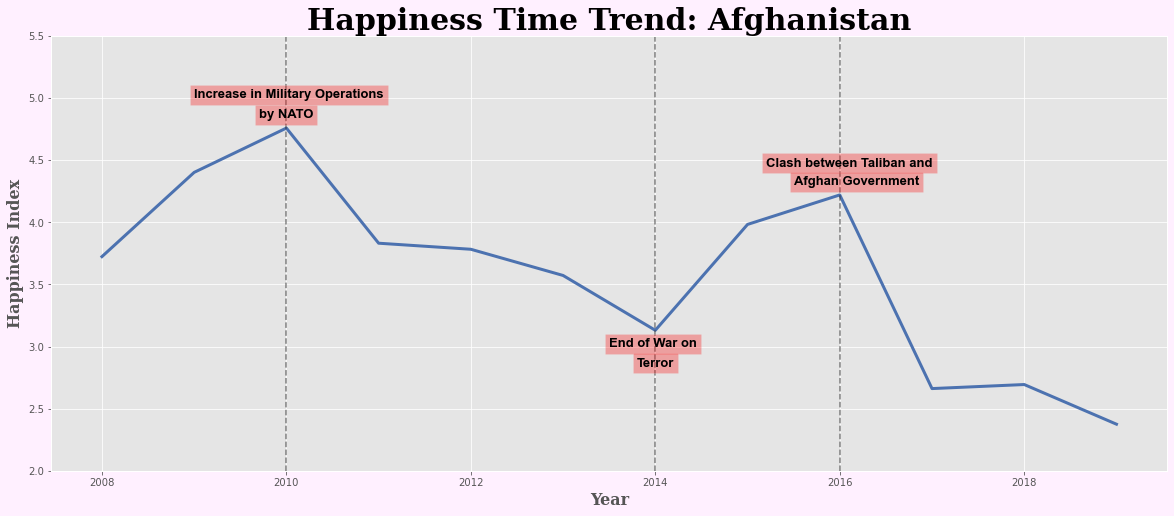

In [11]:
#Lineplot for Afghanistan


df=master_file.loc[master_file['Country']=='Afghanistan'].loc[:,['Happiness_index', 'Year', 'Country']]

fig, ax = plt.subplots(figsize=def_size)

sns.lineplot(
    x=df['Year'], 
    y=df["Happiness_index"],
    hue=df["Country"],
    palette="deep", 
    dashes=False, lw=3, 
    legend=False
    )
ax.set_ylim([2,5.5]) #Customize y-axis limits

#Add verticle lines at 2010,2014 and 2016

for i in [2010,2014,2016]:
    ax.axvline(i,color=tuple(np.array([50, 50, 50,150]) / 255),linestyle='--',
    linewidth=1.5) 

#Customize Annotations


font_tex= def_font.copy() #Set font for annotations
font_tex['family']= 'Arial'
font_tex['size']= 13

#Add text for the 2010 verticle line
tex1= ax.text(2009, 5, "Increase in Military Operations", fontdict=font_tex) 
tex2= ax.text(2009.7, 4.84, "by NATO",fontdict=font_tex)

#Add text for the 2014 verticle line
tex3= ax.text(2013.5, 3, "End of War on",fontdict=font_tex) 
tex4= ax.text(2013.8, 2.84, "Terror",fontdict=font_tex)

#Add text for the 2016 verticle line
tex5= ax.text(2015.2, 4.45, "Clash between Taliban and",fontdict=font_tex) 
tex6= ax.text(2015.5, 4.3, "Afghan Government",fontdict=font_tex)


#Add red background for annotations
for i in [tex1,tex2,tex3,tex4,tex5,tex6]:
    i.set_bbox(dict(facecolor='red', alpha=0.3))


#Set titles, labels and background 
ax.set_title('Happiness Time Trend: Afghanistan', loc='center', fontdict=def_font_title)
ax.set_xlabel('Year', fontdict=def_font)
ax.set_ylabel('Happiness Index', fontdict=def_font)
fig.set_facecolor(background)

In the chart above we clearly see how major political events have impacted the happiness index values for Afghanistan. Foloowing disressfull events such as
***Increase in Military Operations*** in 2010 and ***Clash between Taliban and the Afghan Government*** in 2016 we see a dip in the happiness index for the country. On the other hand, stablilizing events such as the ***End of war on Terror*** in 2014 have resulted in a rise in the index values.

***Peace Index***

The code below plots the trend for the Peace Index using the plot_trends function defined earlier

Text(2018.5, 3.86, 'Somalia')

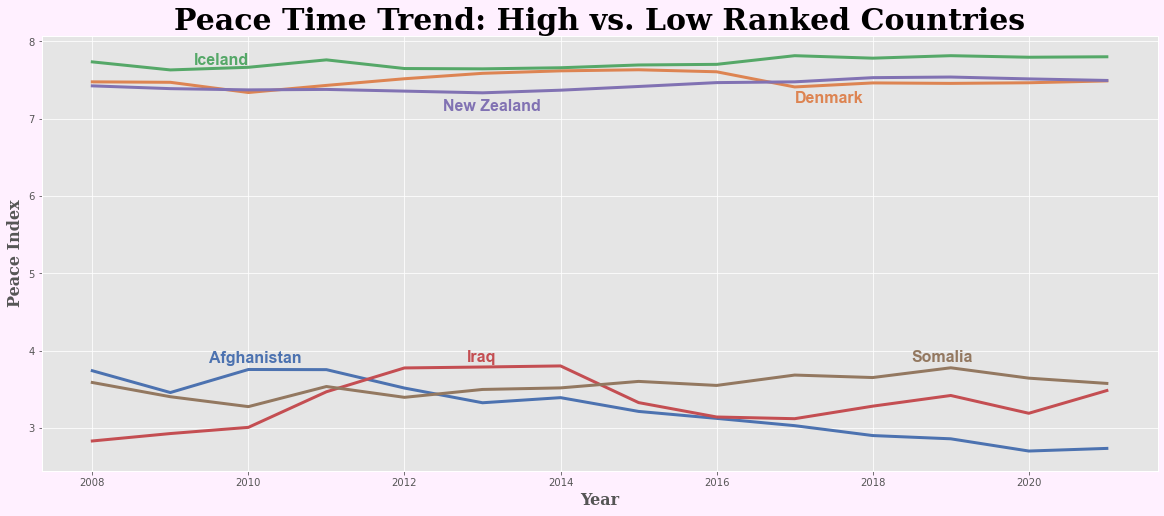

In [12]:
fig, ax = plt.subplots(figsize=def_size)
plot_trends("Peace",ax)

#Add customized annotations

ax.text(2017,7.2,"Denmark",color=color_list[1],fontdict=font)
ax.text(2012.5,7.1,"New Zealand",color=color_list[4],fontdict=font)
ax.text(2009.3,7.7,"Iceland",color=color_list[2],fontdict=font)

ax.text(2012.8,3.86,"Iraq",color=color_list[3],fontdict=font)
ax.text(2009.5,3.84,"Afghanistan",color=color_list[0],fontdict=font)
ax.text(2018.5,3.86,"Somalia",color=color_list[5],fontdict=font)



We analyse the time trends of the top 3 countries with the best average peace index and 3 countries with the worst average. The peace index values of the bottom 3 countries still exhibis more volatility than the top 3 countries, however its not as much as it was for the happiness index.  The index ranges from around 2.7 to 3.8 for the bottom 3. For the top ranked countries, it vares even less (from around 7.4 to 7.6).

The plot above shows that Iceland has persistently maintained the highest peace index value since 2008. 

## Correlations

We examine how factors such as Log GDP per Capita, Social Support, Healthy Life Expectancy at birth, degree of autonomy (Freedom to make life choices) and level of Generosity in the country correlate with the happiness index. We also analyze the correlation between the peace index and the happiness index. The following correlation matrix show how weakly or strongly  the variables correlate with each other:

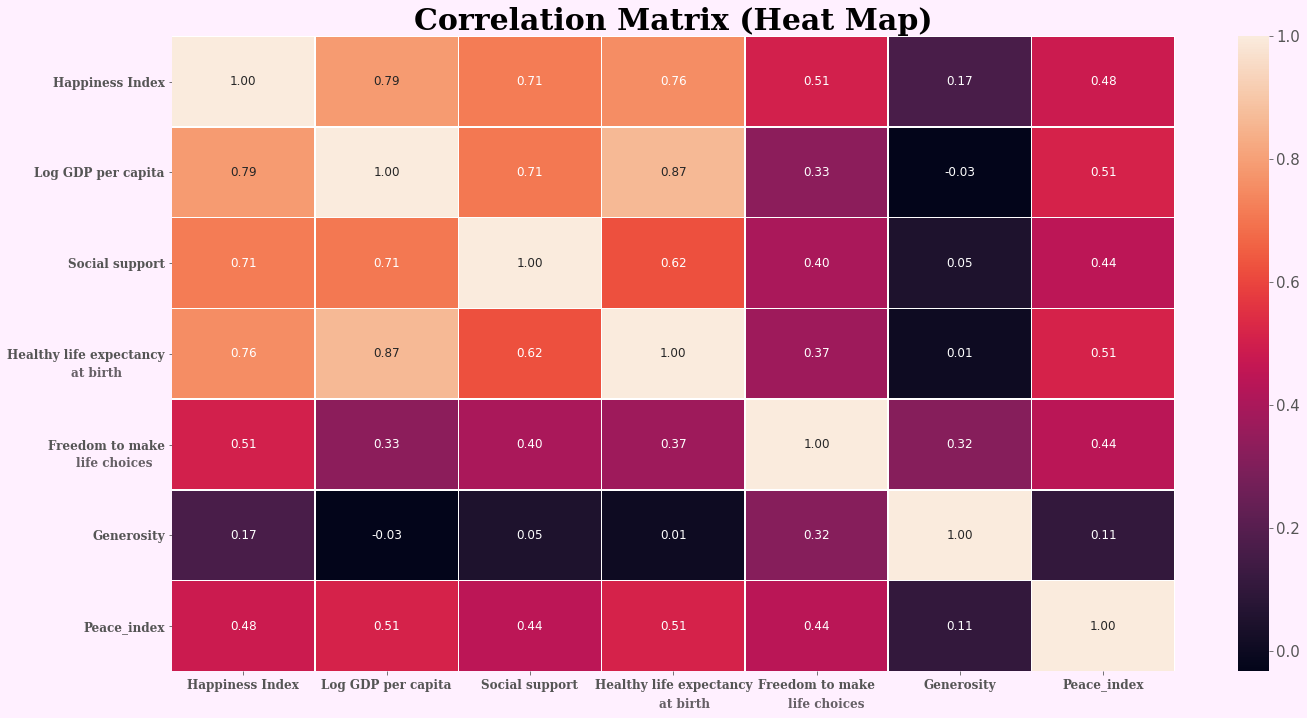

In [13]:
fig,ax = plt.subplots(figsize=(20,10))

#Make Correlation Matrix

#Shorten column names for better visualization, the removed part is added as text later
data= master_file.rename(columns={"Happiness_index":"Happiness Index", 
    "Healthy life expectancy at birth":"Healthy life expectancy",
    "Freedom to make life choices":"Freedom to make"}).dropna().iloc[:,np.r_[2:8, 12]].corr()

#Plot heatmap
sns.heatmap(data, annot=True, linewidths=.5, fmt= '.2f',ax=ax,annot_kws={"fontsize":12})

#Add text for column names shortened earlier

font_corr = def_font.copy()
font_corr['size']=12

ax.text(-0.7,3.75,"at birth",color=(0,0,0,0.6),fontdict=font_corr)
ax.text(-0.67,4.75,"life choices",color=(0,0,0,0.6),fontdict=font_corr)

ax.text(3.4,7.4,"at birth",color=(0,0,0,0.6),fontdict=font_corr)
ax.text(4.3,7.4,"life choices",color=(0,0,0,0.6),fontdict=font_corr)

#Change colorbar ticks fontsize
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

#Customize x and y ticks
labs= data.index.to_list()
ax.set_xticklabels(labs,rotation=0,fontdict=font_corr)
ax.set_yticklabels(labs,fontdict=font_corr)



ax.set_title("Correlation Matrix (Heat Map)",fontdict=def_font_title)
fig.set_facecolor(background)
fig.tight_layout()

Healthy life expectancy at birth, social support and GDP per capita have a strong positive correlation with the happiness index. Factors such as generosity and freedom to make life choices do not have a strong correlation with the index. Peace index has a correlation of only 0.5 with the happiness index, implying that even though these indices move in the same direction as expected, the correlation is not strong. Factors which which correlate with the happiness scores, do not seem to have a strong correlaton with the peace index either. 
<break>
    
    
We examine in further detail factors which have the highest positive correlation with the happiness scores in the first 3 scatter plots below. As can be seen from the heatmap, these factors are Log GDP per Capita, Social Support and Healthy Life Expectancy at birth. In the end we also look at the relationship between the peace and the happiness index in the last scatter plot. In each scatter plot we plot a regression line to identify the trend.

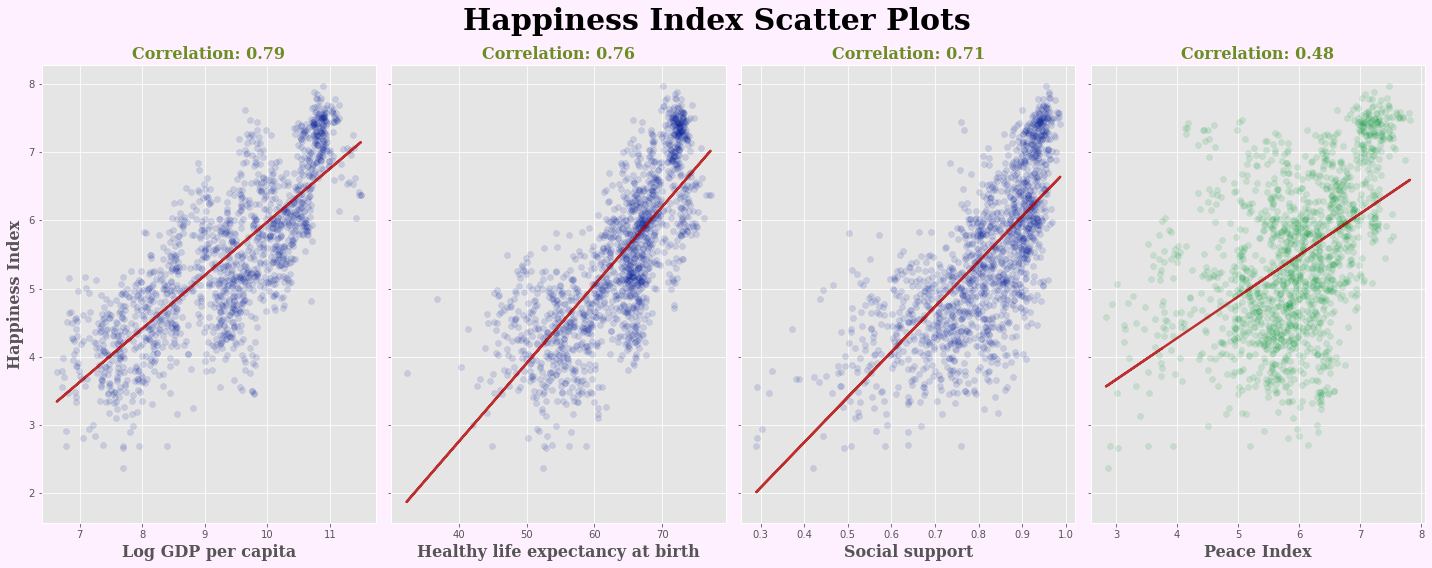

In [14]:

data= master_file.dropna()

#Define function for regression line
def reg_line(data,xcol,ax):

    """
    This function takes in data and another variable name (from Log GDP per capita,
    Healthy life expectancy at birth,Social support or Peace_index) to draw a regression line between
    happiness index and the specified column. The correlation between the two is displayed in the title of the plot.

    Paramters
    ---------
    df: pd.Dataframe
        A copy of the master_file dataset with null values dropped

    index: string
        The name of the relevant variable (Log GDP per capita/Healthy life expectancy at birth/Social 
        support/Peace_index)
    
    ax: axes object
        Axes on which we will plot the regression line
        
    Returns
    -------
    ax: axes object
        The axes object updated with the regression line and correlation value in the title
    """
    assert (xcol=="Log GDP per capita") | (xcol=="Healthy life expectancy at birth") | (
        xcol=="Social support") | (xcol=="Peace_index")

    reg = smf.ols('Q("Happiness_index") ~ Q(xcol)',data).fit()
    data['yhat'] = reg.predict()
    #plot regression line with a shade of red
    #set alpha to a high value to accentuate the regression line
    data.set_index(xcol)['yhat'].plot(ax=ax,color=(0.7,0,0,0.8),lw=2.4) 
    data= data.drop(columns="yhat")                                    
    cor= data[["Happiness_index",xcol]].corr().iloc[0,1].round(2)
    ax.set_title("Correlation: "+str(cor),color='olivedrab',fontdict=def_font)
    return ax


fig, ax = plt.subplots(nrows=1,ncols=4, figsize=def_size, sharey=True)

s=0
for i in ["Log GDP per capita","Healthy life expectancy at birth","Social support"]:
    #plot pale blue scatter plots with alpha set to a low value
    ax[s].scatter(x=data[i],y=data['Happiness_index'],color=(0,0.1,0.6,0.13)) 
    ax[s].set_xlabel(i,fontdict=def_font)     
    reg_line(data,i,ax[s]) #plot regression line
    s+=1

#plot pale green scatter plot for peace. Alpha set to a low value
ax[3].scatter(x=data['Peace_index'],y=data['Happiness_index'],color=(0,0.6,0.2,0.13))
reg_line(data,'Peace_index',ax[3])
ax[3].set_xlabel("Peace Index",fontdict=def_font)

ax[0].set_ylabel("Happiness Index",fontdict=def_font)


fig.suptitle("Happiness Index Scatter Plots",fontproperties=def_font_title)
fig.set_facecolor(background)
fig.tight_layout()

The scatterplots above show the strong positive correlation of the Happiness Index with the Log GDP per Capita,
Healthy life expectancy at birth and Social Support.

As for peace and happiness, we can see from the last scatter plot that the relationship between the two indices,
while positive, is not very definite and strong.

***Geographic Map***

We now analyze wether there is a relationship between index values and geographical proximity i.e countries geographically close to each other tend to have similar index values.

For this we plot a Choropleth using Plotly. This is an interactive world map in which each country is colored 
according to a colorscale representing the respective index values. Hovering over the map displays the name of 
the country and the index value. We make seperate plots for happiness and peace

For happiness the countries are colored according to the tropic color scheme, as per which countries
with higher index values are colored on the turquoise scale (higher the magnitude, darker the turquois) and countries with lower values are colored on the pink scale (lower the values deeper the pink).

For happiness the countries are colored according to the fall color scheme, where the colorscale starts from dark green for the lowest index values, then lightens as the index increases and then becomes orange for the higher values (highest values are the deepest orange).

We plot the map for the index values in 2020.

In [15]:
#Get relevant datasets for each map

#Dataset for peace
geo_peace= peace_index.rename(columns={"Peace_index":"Index"}).query("Year<2021")

#Dataset for happiness

#Cleaning for missing country codes
geo_hap= master_file.rename(columns={"Happiness_index":"Index"}).query("Year>2007")
code_dict= {"Hong Kong S.A.R. of China":"HKG", "Malta":"MLT", "Belize":"BLZ","Comoros":"COM",	
"Luxembourg":"LUX","Maldives":"MDV","Suriname":"SUR","Swaziland":"SWZ"}

for i,j in code_dict.items():
    geo_hap.loc[geo_hap["Country"]==i,"Code"]= j

In [16]:

def map(df,year:int,index:str,color_scale:str,reverse:bool):

    """
    This function takes in an index name (Happiness or Peace), the relevant dataset,year value for
    the year we want the world map for a color scale of our choice and we a True/False value representing 
    on wether we want a reversescale for the colorbar or not
    
    Paramters
    ---------
    df: pd.Dataframe
        geo_peace or geo_hap

    index: string
        The name of the relevant index (Happiness/Peace )for the trend
    
    color_scale: string
        Color Scale for color bar
    
    reverse:bool
        True/False for reverse scale
        
    Returns
    -------
    Interactive world map (Choropleth)
    """
    
    assert type(df) == pd.core.frame.DataFrame
    assert type(index) == str
    assert type(color_scale) == str
    assert type(reverse) == bool

    assert (index=="Happiness") | (index=="Peace")

    df= df.query("Year==@year")
    fig = go.Figure(data=go.Choropleth(
        locations = df['Code'], #locations identified based on country code
        z = df['Index'],        #color varies based on magnitude of index
        text = df['Country'],   
        colorscale = color_scale,
        autocolorscale=False,
        reversescale=reverse,
        marker_line_color='black',
        marker_line_width=1,
        colorbar=dict(title={'text':'<b>'+index+' Index </b>','font':{'size':20,'family':'serif'}}) 
    ))

    fig.update_layout(
        title_text='<b>World Map for Global '+index+' Index ('+str(year)+
        ')</b><br><sup>Hover over for Index values and Country names</sup>',
        titlefont=dict(size =30, color='black', family='serif'),
        title_x=0.5,
        geo=dict(
        landcolor = 'rgba(175, 165, 166,0.7)', #customize grey color with missing values
        showcountries = True,
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular',
        bgcolor='rgb(255,240,255)' #customize background color to our default value
        ),
        margin=dict(l=10, r=10, t=70, b=10),
        paper_bgcolor='rgb(255,240,255)',
    )

    fig.show() 

def map_year(year=2020):

    """
    This function just takes in a year value and the runs the function defined above for both peace and
    happiness

    Paramters
    ---------
    year: int
        Year for which we want the world map
        
    Returns
    -------
    Interactive world maps for happiness and peace (Choropleth)
    """

    assert type(year)==int
    assert (year<2021) & (year>2007)
    
    map(geo_hap,year,"Happiness","fall",False) #Fall color scale for happiness, reversescale=True
    map(geo_peace,year,"Peace","tropic",True) #Tropic color scale for peace, reversescale=True
    

map_year(2020)

The plots above show that we do see index values being clustred together based on geographical proximity.

For the global happiness index we see that the dark orange shades (representing high levels of happiness)
are clustered in Western and Northen Europe and North America. Similarly we see that the darker greens (representing low levels of happiness) are clustred in southern and eastern africa and south asia). Central Asian countries mostly colored as yellow tend to have moderate happiness levels.

Similarly for the peace index we see that that Western and Northen Europe and North America are colored
according to deepert shades of turquoise (higher peace) and the deepest pink is clustered in Central Africa, Middle East and Asia.


## Does the Gender of the Head of State/Government matter?

In this section we analyze wether countries led by females tend to fare better than countries than countries led by males especially during the global pandemic year i.e 2020.

We first analyze data for the year 2020 and check wether female led countried tend to have higher avergaes for the
happiness and peace index. We also look at the LOG GDP per capita.

In the end we analyze the 2008-2020 time period as an extension.

The code below first identifies head of states who were in power during the year 2020. To do this we filter our
female head of state on countries where the mandate of the female head started before the beginning of next year
i.e Jan 01 2021 and ended after the end of last year i.e 31 Dec 2019. In other words, we keep observations 
where start date< 2021-01-01 and end date> 2019-12-31.

We then merge our dataset with the happiness and peace data, and create variables representing wether the head of
state was male or female.

Next we calculate the mean values of Happiness and Peace Index (as well as LOG GDP per Capita) for each gender 
category and plot the averages for each group using a barchart. 

In [17]:
def hos_analysis(year):

    """
    This function takes in a year value and then identfies the countries (and leaders) in the Female Head
    of State Data who were in power during this year. We keep observation where the start date< Jan 01 of next year
    and end date> Dec 31 of last year

    Paramters
    ---------
    year: int
        Year for which we want our analysis
        
    Returns
    -------
    data: pd.Dataframe
        Dataset for a particular year identifying countries which had a female head of state.
    """
    
    assert type(year)==int
    assert (year<2021) & (year>2007)
    
    #Keep relevant countries
    df_hos=F_Head_of_State.loc[(
        F_Head_of_State["Start_date"]< str(year+1)+'-01-01') & (
        F_Head_of_State["End_date"]> str(year-1)+'-12-31'),:]
    
    #Merge with relevant columns from master file
    df_hnp=master_file.loc[master_file['Year']==year,["Country",
    "Year","Happiness_index","Log GDP per capita","Peace_index"]]
    
    #Our data is only for a particular year so we only need to merge on country
    merged=df_hnp.merge(df_hos, how='left', on='Country') 
    
    #Make binary variable which takes a value of 1 for countries with female heads of states and 0 otherwise
    merged['Female_head'] = merged['Name'].apply(lambda x: 1 if pd.notnull(x) else 0)  

    #HOS Gender column with values male and female                                                            
    merged["HOS Gender"]= np.where(merged["Female_head"]==1,"Female","Male")
    return merged.iloc[:,[0,5,1,6,7,2,4,3,8,9]].sort_values("Female_head", ascending=False)

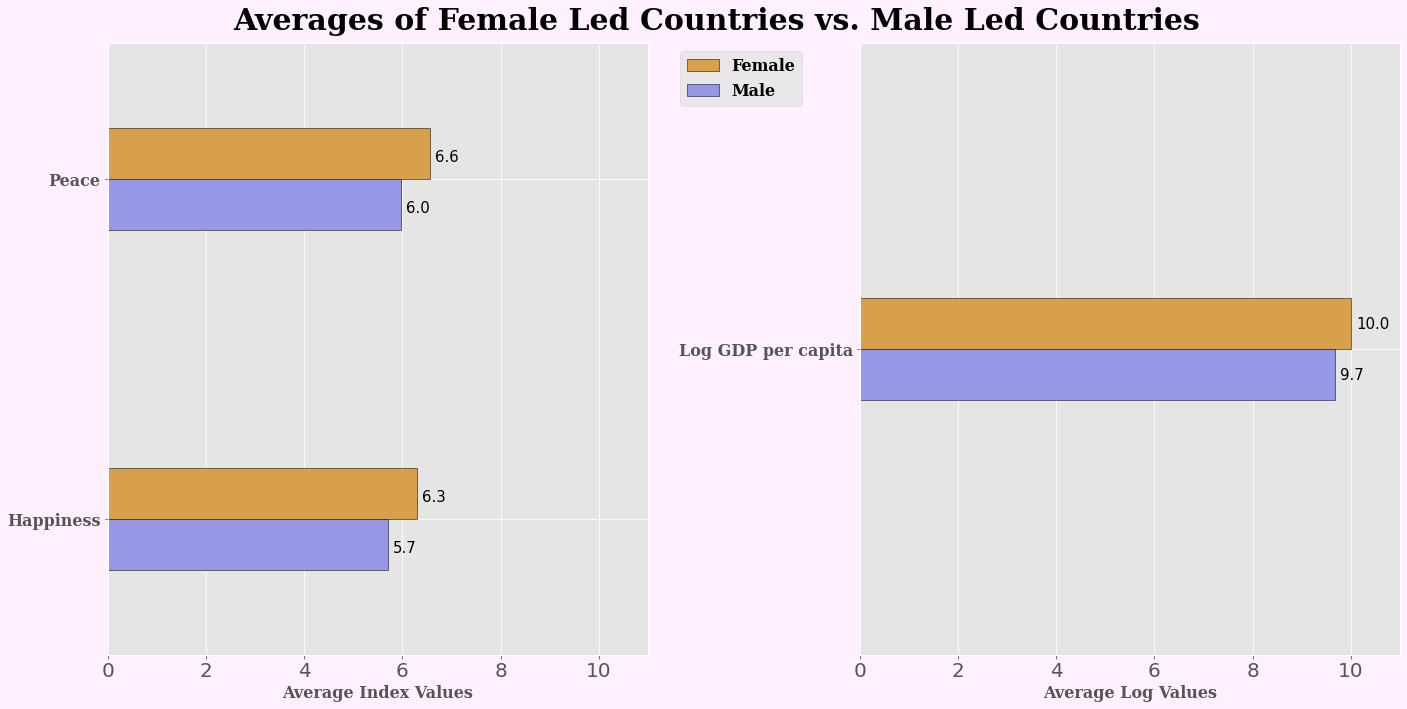

In [18]:
#Store result from the function in a dataset and drop unnecessary columns
fhos_2020= hos_analysis(2020).drop(["Start_date","End_date","Year","Female_head","Name"], axis=1).dropna()

#Calculate means
means_2020= fhos_2020.groupby("HOS Gender").agg("mean").iloc[[1,0],:]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10),sharex=True)

#Set color directory for consistency

g_colors= {'Male':(0.585,0.5976,0.9),'Female':(0.85,0.629,0.2975)}

#Subplot 1

#Plot barchart for Happiness and Peace
means_2020.T.iloc[:2,:].plot(
    ax=ax[0],kind='barh',color=[g_colors[v] for v in g_colors.keys()],edgecolor='k',label=True,fontsize=20,width=0.3)

ax[0].set_xlabel("Average Index Values",fontdict=def_font)
ax[0].set_yticklabels(["Happiness","Peace"],fontdict=def_font)

#Customize order of labels in legend
handles, labels = ax[0].get_legend_handles_labels()

#specify order of items in legend
order = [1,0]

#add legend to plot
ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right',
bbox_to_anchor=(1.3, 1),prop=def_font)


s=0
for i in ["Happiness_index","Peace_index"]:
    ax[0].text(means_2020.loc["Female",i]+0.1,s+0.05,str(means_2020.loc["Female",i].round(1)),fontsize=15)
    ax[0].text(means_2020.loc["Male",i]+0.1,s-0.1,str(means_2020.loc["Male",i].round(1)),fontsize=15)
    s+=1


#Subplot 2
#Plot barchart for Log GDP per capita
means_2020.iloc[:,2].to_frame().T.plot(ax=ax[1],kind='barh',
            color=[g_colors[v] for v in g_colors.keys()],edgecolor='k',label=True,legend=False,width=0.1, 
            fontsize=20)
ax[1].set_xlabel("Average Log Values",fontdict=def_font)


#Add annotations for bar chart heights
ax[1].text(means_2020.loc["Female","Log GDP per capita"]+0.1,0.02,str(means_2020.loc["Female","Log GDP per capita"].round(1)),fontsize=15)
ax[1].text(means_2020.loc["Male","Log GDP per capita"]+0.1,-0.03,str(means_2020.loc["Male","Log GDP per capita"].round(1)),fontsize=15)
ax[1].set_xlim([0,11])
ax[1].set_yticklabels(["Log GDP per capita"],fontdict=def_font)


fig.suptitle("Averages of Female Led Countries vs. Male Led Countries",fontproperties=def_font_title)
fig.set_facecolor(background)
fig.subplots_adjust(wspace=10)
fig.tight_layout()


The barcharts above show that countries led by females do in fact tend to fare better. For both peace and happiness 
we see that the avergaes are higher by 0.6 points for females than males

We explore wether this behavior is also similar for other factors such as the LOG GDP per Capita and we see that 
while female led countries tend to fare better in that category too, however the difference is much less now. 

This motivates us to explore wether such gendered difference is also present in other years. Subsequently, we 
extend our anaysis to the entire time period from 2008-2020.

We first make a panel dataset by running the hos_analysis function defined above for each year from
2008-2021 and the concatinating all datasets together. This gives us a full panel where for each year we can
identify which countries were led by females heads of states.

In [19]:
full_panel= hos_analysis(2008)
for i in range(2009,2021):
    full_panel= pd.concat([full_panel,hos_analysis(i)]).drop(["Start_date","End_date","Log GDP per capita"], axis=1)
    full_panel["Name"].fillna("NA",inplace=True)
    full_panel= full_panel.dropna()


Next using our full panel we use lineplots to plot for each year the average index values for female led countries
and the average values for male led countries. We also include a lineplot for the full sample i.e the average index
values of all countries. We plot seperately for happiness and peace

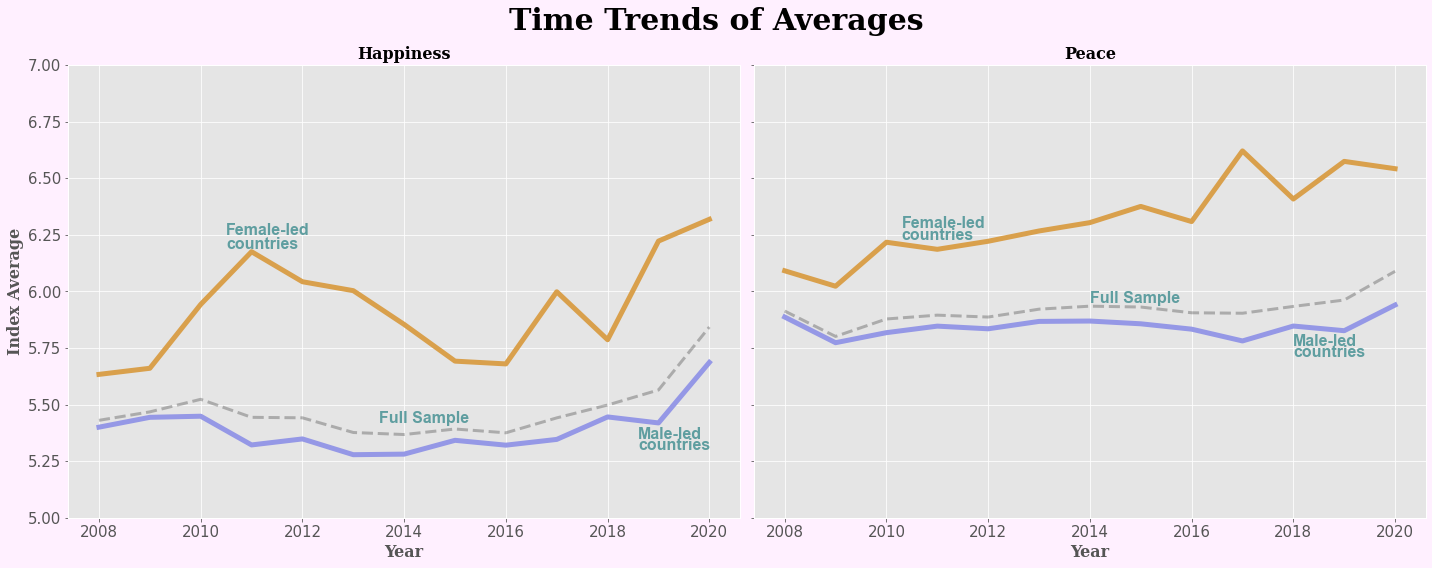

In [20]:
fig,ax= plt.subplots(nrows=1,ncols=2, figsize=def_size, sharex=True,sharey=True)

s=0

#Line Plots for Happiness and Peace
for j in ["Happiness_index","Peace_index"]:
    #Plot means for females and males 
    for i in full_panel['HOS Gender'].unique():
        full_panel.loc[full_panel['HOS Gender']==i,["Year",j]].groupby("Year")[j].mean().plot(
            ax=ax[s],color=g_colors[i], linewidth=5,legend=False,fontsize=15)
    #Full sample plot
    full_panel.loc[:,["Year",j]].groupby("Year")[j].mean().plot(ax=ax[s],
    color=(0,0,0,0.25),label='full',linewidth=3,linestyle='--')
    ax[s].set_title(j.split("_")[0],fontdict=def_font)
    ax[s].set_ylabel("Index Average",fontdict=def_font)
    ax[s].set_xlabel("Year",fontdict=def_font)
    ax[s].set_ylim([5,7])
    s+=1

font_annot= def_font.copy()
font_annot['family']= 'Arial'
font_annot['color']='cadetblue'


#Add annotations
ax[0].text(2010.5,6.25,"Female-led",fontdict=font_annot)
ax[0].text(2010.5,6.19,"countries",fontdict=font_annot)
ax[0].text(2013.5,5.42,"Full Sample",fontdict=font_annot)
ax[0].text(2018.6,5.35,"Male-led",fontdict=font_annot)
ax[0].text(2018.6,5.3,"countries",fontdict=font_annot)

ax[1].text(2010.3,6.28,"Female-led",fontdict=font_annot)
ax[1].text(2010.3,6.23,"countries",fontdict=font_annot)
ax[1].text(2014,5.95,"Full Sample",fontdict=font_annot)
ax[1].text(2018,5.76,"Male-led",fontdict=font_annot)
ax[1].text(2018,5.71,"countries",fontdict=font_annot)

fig.suptitle("Time Trends of Averages", fontproperties=def_font_title)
fig.set_facecolor(background)
fig.tight_layout()




From the plots above, we see that female led countries have actually fared better than male led countries at all years. We see this for both the happiness and the peace index. However we also notice that the for both indices,
the line plots for female led countries are more volatile than those for male led countries.

We also see that the full sample is much closer to the male led countries line in both the plots. Thus it appears
that the full sample line is being weighed down by the relatively poor performance of male led countries.

Next we then extend our analysis to focus on two subsets of the data for the relative indices; the top 10 countries
and the bottom 10 countries. Then within each subset we see what proportion of the heads of states are females.

In other words, for each index we look at the top 10 countries. We then see what percentage of these countries were led by females. We then do the same for the bottom 10. We analyze each index seperately.

In [21]:
def stats_data(df):

    """
    This function takes in a sorted (by index value) dataframe for a particular index and year. 
    It combines country names with head of state names in a single column.
    
    It then produces two subsets of data, one for the top 10 and one for the worst 10.
    It then uses the female head binary variable to calculate the proportion of female heads, as well
    as the female-led country (and head of state) names in each subset

    All data is concatenated in a single dataframe

    Paramters
    ---------
    df: pd.Dataframe
        Relevant sorted dataset for a particular index and year
        
    Returns
    -------
    data: pd.Dataframe
        Dataframe for a particular index and year, identifying the proprtion of countries (Top and worst 10)
        with female heads of states, as well as the country and head of state names for these countries.
    """

    df["Country"]= df["Country"]+str(" (")+df["Name"]+str(")")
    #Top 10
    df1= df.head(10)
    Prop_T10= df1["Female_head"].mean()*100
    C_T10= str(df1.query("Female_head==1")["Country"].to_list()).replace("[","").replace("\'","").replace("]","")
    
    #Bottom 10
    df2= df.tail(10)
    Prop_W10= df2["Female_head"].mean()*100
    C_W10= str(df2.query("Female_head==1")["Country"].to_list()).replace("[","").replace("\'","").replace("]","")
    
    year= df["Year"][0]

    data1 = pd.DataFrame([{"Year":year,"Category":"Top 10" ,"Fem HOS (%)": Prop_T10,"Countries and Heads":C_T10}]).set_index('Year')
    data2 = pd.DataFrame([{"Year":year,"Category":"Worst 10","Fem HOS (%)": Prop_W10,"Countries and Heads":C_W10}]).set_index('Year')
    
    return pd.concat([data1,data2])

def stats(year,index):
    """
    This function takes in a particular year and index name. It filters the full panel dataset on the year
    and then sorts it by the index. 

    It the runs the stats_data function for this dataset.

    Paramters
    ---------
    
    year: int
        Relevant year

    index: string
        Relevant index name
        
    Returns
    -------
    data: pd.Dataframe
        Dataframe for a particular index and year, identifying the proprtion of countries (Top and worst 10)
        with female heads of states, as well as the country and head of state names for these countries.
    """
    df= full_panel.query("Year== @year")
    
    df_i= df.sort_values(index, ascending=False)
    data= stats_data(df_i).fillna("")

    return data
    
def fullstats(index):
    """
    This function creates a full panel of dataset by running the stats function defined above on all years from
    2008 to 2020

    Paramters
    ---------
    index: string
        Relevant index name   
    Returns
    -------
    data: pd.Dataframe
        Full panel dataset which for each year identifies the proprtion of countries (Top and worst 10)
        with female heads of states, as well as the country and head of state names for these countries.
    """
    full_stats= stats(2008,index)
    for i in range(2009,2021):
        full_stats= pd.concat([full_stats,stats(i,index)])
    return full_stats.reset_index()

The code below creates interactive barcharts to display the results from the function above for a particular index.
On the x-axis we have years and the y-axis we have the percentage of heads of states which are females.
We have seperate bars for Top 10 and Worst 10 countries in each year. We analyze peace and happiness sepereately

The bar chart also shows horizonatal lines for the min, mean and max of percentage of heads of states which are
females in the Top 10 Countries category. Hoevering over each bar displays the country and head of state names for
female led countries

In [22]:

def bars(index):

    """
    This function takes in an index name, creates the full stats data for the particular index
    and then displays the output in an interactive barchart.
    

    Paramters
    ---------
    index: string
           Relevant index name   
    Returns
    -------
    fig:   plotly figure
           Plotly Barchart 
    """
    assert (index=="Happiness") | (index=="Peace")
    
    df= fullstats(index+"_index")

    fig = px.bar(df, x='Year',y='Fem HOS (%)',hover_data=['Countries and Heads'], color='Category', text='Fem HOS (%)',
    color_discrete_sequence=["rgba(141,211,199,0.7)", "rgba(217,95,2,0.7)"])
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside',textfont_color="rgba(0,0,0,0.6)")

    fig.update_layout(
        title_text='<b>'+index+
        ': Percentage of H.O.S which are Female in Top 10 and Worst 10 Countries </b><br><sup>Hover'+
        ' over for names of countries led by females (head names in brackets) </sup>',
        titlefont=dict(size =25, color='black', family='serif'),
        title_x=0.5,
        barmode='group', 
        bargap=0.15, # gap between bars of adjacent location coordinates.
        bargroupgap=0.1, # gap between bars of the same location coordinate.
        margin=dict(l=10, r=10, t=70, b=10),
        paper_bgcolor='rgb(255,240,255)',
        xaxis = dict(
        tickmode = 'linear',
        tickvals = list(range(2009,2021))),
        yaxis_ticksuffix="%"
    )

    fig.update_yaxes(title={'text':'<b> Percentage of H.O.S which are Female </b>','font':{'size':15,'family':'serif'}})
    fig.update_xaxes(title={'text':'<b> Year </b>','font':{'size':15,'family':'serif'}})
    

    #Add horizontal lines

    h_lines= df.loc[df["Category"]=="Top 10","Fem HOS (%)"]
    for i in [min,np.mean,max]:
        y_l=h_lines.agg(i)
        fig.add_hline(y=y_l,line_width=1, line_dash="dot", line_color="rgba(0,0,255,0.7)")
    
    #Add annotations
    font_p= dict(color="rgba(0,0,255,0.7)",size=10)
            
    fig.add_annotation(x=2012, y=h_lines.agg(max),
            text=  "<b> Max (%) in Top 10 </b>",
            showarrow=False, yshift=10,
            font=font_p)

    fig.add_annotation(x=2014.9, y=h_lines.agg(np.mean),
            text=  "<b> Mean (%) in Top 10 </b>",
            showarrow=False, yshift=10,
            font=font_p)

    fig.add_annotation(x=2017.3, y=h_lines.agg(np.min),
            text=  "<b> Min (%) </b>",
            showarrow=False, yshift=40,
            font=font_p)
    fig.add_annotation(x=2017.3, y=h_lines.agg(np.min),
            text=  "<b> in </b>",
            showarrow=False, yshift=25,
            font=font_p)
    fig.add_annotation(x=2017.3, y=h_lines.agg(np.min),
            text=  "<b> Top 10 </b>",
            showarrow=False, yshift=10,
            font=font_p)
            
    fig.show()

#Plot bar chart for happiness
bars("Happiness") 

The barchart above shows that female head of state representation has always been present in the Top 10 country
for each year. In other words there is no such year where this percentage was 0. Female representation has ranged
from a minimum of 10% to a maximum of 70% (in the year 2020). The average value in the top 10 category
for this representation is around 30%

For the worst 10 category we see that for most years this representation was 0 and at maximum it has only been 20%

We see that for most years female representation in the top 10 outnumbers the representation in the worst 10.

In [23]:

#Plot bar chart for peace
bars("Peace")

The barchart above again shows that female head of state representation has always been present in the Top 10 countries
for each year for peace, ranging from a minimum of 10 to a maximum of 50 in 2019. I

For the worst 10 category we see that except for 2 years years this representation was 0 and even during these
two years there was just 1 out of the 10 countries which were led by females (10% Representation)

Hence from the analysis above it shows that female heads of states tend to be very heavily represented in the 
top 10 categories for both happiness and peace. Whereas the worse 10 countries tend to be mainly led by males

# Conclusion

In this analysis we observe multiple insights. Individual time trends for average values of both peace and happiness show that low ranked countries tend to exhibit more volatility than high ranked countries. We also look at the impact of major political events on the trend for the happiness score on Afghanistan. We notice that the happiness index appears to be quite strongly correlated with factors such as Log GDP per Capita, Healthy Life Expectancy at birth and Social Support. We see a positive, but moderate correlation between peace and happiness. We also notice that geographical proximity plays a role, as in world map for the year 2020, we see that magnitude levels of index values tend to be clustered together.

In the global pandemic year of 2020 we see that the average index levels for female led countries were higher than male led countries for both happiness and peace. We also see that in this year, 7 out of 10 (70%) of the Top 10 Countries for happiness were led by Females. We also see that in 2020, the percentage of head of states which were female attains its maximum value. In contrast only one out of 10 (10%) of the worst 10 countries in 2020 were led by females. For peace the percentage in the top 10 comes down to 40% for females, however, female led countries tend to be both more peaceful and happier.




# Appendix

In this section we describe the process of scraping our data for the female heads of state.

We first need to run the following lines of code in the terminal

    1. Set the current directory to where you want your scrapy project

    You should change the path in front of cd with the path for your own directory

    2. Run the command scrapy startproject <insert name>

    For our code we name the project female_heads_data. This creates a folder named as female_heads_data in our current directory

    3. Set the project folder as your current directory

    4. Run the command scrapy genspider <insert spider file name> <insert the webpage link>

    For our code we name the spider file as fem_head and insert the link to the Wikipedia webpage

***To Run in the Terminal***

cd "..........\Data for Social Skills\Project" 

scrapy startproject female_heads_data

cd female_heads_data

scrapy genspider fem_head en.wikipedia.org/wiki/List_of_elected_and_appointed_female_heads_of_state_and_government

Scrapy has now created a spider file inside our project. It first created the folder for the project named as female_heads_data in our orginal current directory. This project folder will later also contain our csv data after we have crawled the webpage. The female_heads_data contains a subfolder with the same name i.e female_heads_data. This subfolder contains a folder named spiders which contains the fem_head spider file scrapy just created.

You can run the tree command in the terminal to locate this file

We will next edit this fem_head spider file in order to be able to crawl the data. As discussed above the final version of the file has already been created and can be viewed seperately. In order to explain the code inside it, we have copied its contents below for convenience. 

Inside the spider file we first need to remove the slash "/" at the end of the path in the start_urls. This slash creates an error when scrapy tried to 
crawl the webapge and so must be removed.

Next we add our codes inside the parse function. Full details and description of the code are described inside the
docstring of this function.

***SPIDER FILE***

import scrapy

class FemHeadSpider(scrapy.Spider):

    name = 'fem_head' 
    allowed_domains = ['en.wikipedia.org/wiki/List_of_elected_and_appointed_female_heads_of_state_and_government']
    start_urls = ['http://en.wikipedia.org/wiki/List_of_elected_and_appointed_female_heads_of_state_and_government']
    
    # Remove the slash at the end of the path in start_urls if it is still present. 
    # The "/" creates an error when scrapy tries to crawl the data

    def parse(self, response):
        """
        This function aims to extract the name, country, mandate start and mandate end date of each female head of state in the table on the 
        wikipedia page.

        We first identify the tbody of the table and store it in a variable tab. We then exytract the rows of this table in the tr.
        We exclude the first row as it doesnt contain any actual data.
        Then we index over all the rows and for each row we extract the child td.
    
        The wikipedia data of our interest needs to be retrieved from 2 different children ("a" and "span") of this td child.

        We store the text contents of "a" in a variable nam_count as these are the names of the head of the state and the country
        We store the text content of "span" in a variable start_end as these are the mandate start and end dates

        The wikipedia data is not consistent across all rows. The length of the a and span items and the position of their elements 
        varies with each row. 
        Eg. in some rows the start date is the first element of the span item and in some rows it is the second.
        We noticed that the position of the relevant text varies with the length of the item and so we use this with if conditions
        to fix the errors

        Similarly for leaders with mutliple terms, the name and country is provided for the first term but it is missing in the successive 
        terms. 
        If the name and country are not missing then these variables are populated accordingly. If they are missing then the value from
        the previous row is used. 
        They are only missing if they are a successive term, of a head with multiple terms, so using the previous value is valid

        For head of states which are currently in power, we fix the end data as 31 Jan 2022. This is a date larger than all start dates
        in our sample. This is just done to make analysis easier by giving date values to all entries. It doesn't affect our analysis
        otherwise as we will be focusing on 2020 only

        The if conditions take care of all these cleaning errors.

        In the end we store our data in a dictionary named data and we then yield it
        """
        tab= response.xpath('//*[@id="mw-content-text"]/div[1]/table[3]/tbody')
        rows= tab.xpath('.//tr')[1:]
        for row in rows:
            td= row.css("td")
            nam_count= td.css("a::text").getall() #This contains the name of the state and its female head 
            start_end= td.css("span::text").getall() #Start and End Dates of the head's position in power

            #Cleaning
            
            #Extracting Name and Country
            if len(nam_count)>=2:
                name= nam_count[0]    
                country= nam_count[1] 
            
            #Extracting date entries based on each case
            if len(start_end)==5:
                start= start_end[1]
                end= start_end[2]
            if len(start_end)==4:
                start= start_end[2]
                end= start_end[3]
            if len(start_end)==3:
                start= start_end[1]
                end= start_end[2]
            if len(start_end)==2:
                if len(start_end[0])>=4:
                   start= start_end[0]
                   end= start_end[1]
                else:
                   start= start_end[1]
                   end= "31-Jan-22"       #31 Jan 22 entry as end date for heads currently in power
            if len(start_end)==1:
                start= start_end[0]
                end= "31-Jan-22"
            
            
            data={
                "Name": name, 
                "Country":country, 
                "Start_Date":start,
                "End_Date":end
                }
            yield data



Once our spider file is ready, we can scrawl it by running the following command in the terminal

***To Run in the Terminal***

scrapy crawl fem_head -O fem_head.csv

Scrapy has now created a csv named fem_head.csv inside the main scrapy project folder (name female_heads_data).
Thuis is the csv used for our analysis.